Fitting Polynomials
===================

In this exercise, we are going to explore the bias–variance tradeoff
on a illustrative problem, polynomial fitting.

We are now going to use the following model, which can be seen as linear model with enlarged feature space:

$$ 
f(x; \vec\theta) = \sum_{k=0}^{K-1} \theta_k f_k(x) = \theta_0 + \theta_1 x + \ldots \theta_{K-1} x^{K-1},
$$

i.e., one has $f_k(x) = x^k$.  (Note that we are indexing slightly
differently than in the lecture because numpy indices start at zero.)

Write `f_k`, which implements $f_k(x)$, and also a function `fmodel`, which implements $f(x; \vec\theta)$ above

In [1]:
import numpy as np
import matplotlib.pyplot as pl

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-h4fuy3f1 because the default path (/home/e01026902/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def f_k(k, x):
    return x**k
    
def fmodel(x, theta):
    sum = 0
    for k, t in enumerate(theta):
        sum += t*f_k(k, x)
    return sum

In [3]:
np.testing.assert_allclose(f_k(0, 3.0), 1.0, atol=1e-6)
np.testing.assert_allclose(f_k(1, 2.5), 2.5, atol=1e-6)
np.testing.assert_allclose(f_k(2, 4.0), 16.0, atol=1e-6)

np.testing.assert_allclose(fmodel(3.0, np.array([.4])), 0.4, atol=1e-6)
np.testing.assert_allclose(fmodel(1.0, np.array([.7, 0.5])), 1.2, atol=1e-6)
np.testing.assert_allclose(fmodel(1.0, np.array([.7, 0.5])), 1.2, atol=1e-6)


Load and randomize data set
-------------------------------------
Instead of needing to randomly select the data by throwing dice,
a simpler technique is to just randomize the observations.  Afterwards,
we can simply select the first $n$ rows and be sure we are not biasing
our calculations.

 1. Use numpy's `loadtxt` function to again load a data matrix, where
    each row corresponds to an observation with $x$ and $y$ value,
    from the file `poly.txt`.
  
 2. Randomly permute the rows in the data matrix (Hint: look
    through the methods for `random`)
 
 3. Again split up the result into a `x` and `y` vector.

In [4]:
random = np.random.default_rng(777)

In [5]:
data = np.loadtxt("poly.txt")
random.shuffle(data)
x = data[:,0]
y = data[:,1]

In [6]:
print(x[:5])
print(y[:5])

[ 0.3925519  0.7892026 -0.6184356  1.689792   1.859727 ]
[-0.1610474   2.108433    1.086904    1.943973    0.00322987]


In [7]:
random?

Type:        Generator
String form: Generator(PCG64)
File:        /opt/conda/lib/python3.10/site-packages/numpy/random/_generator.cpython-310-x86_64-linux-gnu.so
Docstring:  
Generator(bit_generator)

Container for the BitGenerators.

``Generator`` exposes a number of methods for generating random
numbers drawn from a variety of probability distributions. In addition to
the distribution-specific arguments, each method takes a keyword argument
`size` that defaults to ``None``. If `size` is ``None``, then a single
value is generated and returned. If `size` is an integer, then a 1-D
array filled with generated values is returned. If `size` is a tuple,
then an array with that shape is filled and returned.

The function :func:`numpy.random.default_rng` will instantiate
a `Generator` with numpy's default `BitGenerator`.

**No Compatibility Guarantee**

``Generator`` does not provide a version compatibility guarantee. In
particular, as better algorithms evolve the bit stream may change.

Para

In [8]:
assert (x, y) is not None

# Check if permutation did not mess up stuff
_sorted = np.sort(np.rec.fromarrays([x,y], names='x,y'))
np.testing.assert_allclose(_sorted.x, np.loadtxt('poly.txt')[:,0], atol=1e-6)
np.testing.assert_allclose(_sorted.y, np.loadtxt('poly.txt')[:,1], atol=1e-6)

# Check for randomness...
sortedx = (x[1:] > x[:-1]).sum()
assert sortedx > .3 * x.size and sortedx < .7 * x.size

Let's check if we did a good job on randomizing the data.
There is a cute way of doing this:

We again do a scatter plot (`pl.scatter`), where I plot `y`
over `x`.  These plots allow you to use **color** to attach
information to each data point.
We want color to represent the position of the observation
within the array, so we simply pass a vector with indices.
If you like, you can play around with the [`cmap` argument].

If the resulting plot looks a little bit like an impressionist
painting, which the colors nicely scattered, then you did a
good job randomizing.  If you can spot a visible gradient, then
it means that position and index are correlated, and something
went wrong in the randomization.

[`cmap` argument]: https://matplotlib.org/stable/tutorials/colors/colormaps.html

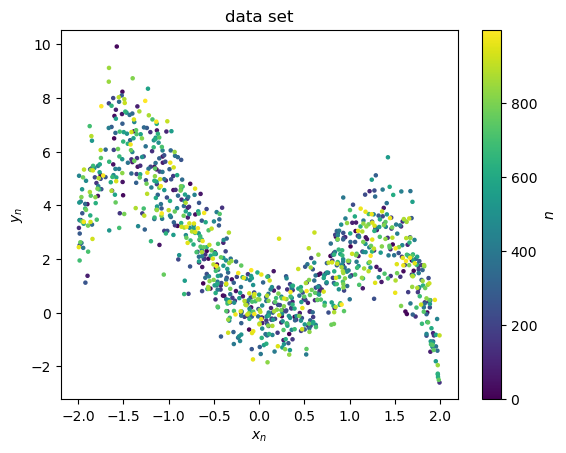

In [9]:
pl.scatter(x, y, c=np.arange(1000), s=5)
pl.xlabel('$x_n$')
pl.ylabel('$y_n$')
pl.title('data set')
pl.colorbar(label='$n$')

Linear model with enlarged feature space
------------------------------
Let's fix the maximum polynomial order at `Kmax=20`.

Now you should construct an augmented "design matrix" `Xtilde` with `N=1000`
rows, corresponding to the observations, and `Kmax=20` columns with the
element $X_{kn} = \tilde x_{n,k} = f_k(x_n)$, i.e., the $k$-th feature of the
$n$-th observation.

In [10]:
Xtilde = np.zeros( (1000, 20) )
for i in range(0, 1000):
    for j in range(0, 20):
        Xtilde[i, j] = f_k(j, x[i])

In [11]:
Xtilde[:4, :4]

array([[ 1.        ,  0.3925519 ,  0.15409699,  0.06049107],
       [ 1.        ,  0.7892026 ,  0.62284074,  0.49154753],
       [ 1.        , -0.6184356 ,  0.38246259, -0.23652848],
       [ 1.        ,  1.689792  ,  2.855397  ,  4.82502701]])

In [12]:
assert (Xtilde,) is not None
assert Xtilde.shape == (1000, 20)

_rowsums = [
    1.00000000e+03,  2.74192173e+01,  1.26907921e+03,  6.80383109e+01,
    3.03906894e+03,  1.55539066e+02,  8.77137073e+03,  3.07412343e+02,
    2.76456589e+04,  3.21997393e+02,  9.16437544e+04, -1.40425556e+03,
    3.13851105e+05, -1.36666460e+04,  1.09962081e+06, -7.87415634e+04,
    3.91828369e+06, -3.86712415e+05,  1.41452574e+07, -1.75920784e+06]
np.testing.assert_allclose(Xtilde[:,:].sum(0), _rowsums, atol=1e-3)

Write the corresponding model function `fmodel_lin` which maps elements `xtilde` ($\tilde x_n$)
to the predicted $y$ (note that this is now a linear model!), given the
model parameters `theta`:
$$
    \hat y_n = f_\mathrm{lin}(\tilde x_n; \vec\theta)
$$

Also implement the cost function, and include a Ridge regularization term,
weighted with `lambda_`:
$$
    \operatorname{cost}(\tilde X, \vec y; \vec\theta, \lambda) 
    = \frac 1N \sum_{n=1}^N | y_n - f_\mathrm{lin}(\tilde x_n; \vec\theta) |^2 + \mbox{(Ridge regularization term)}
$$
You should not use hardcoded values for $N$ or $K$ since we will change them later - infer them from the size of the arguments instead.

**Also note** the additional factor $1/N$ in the first term compared to the lecture (the regularization term is not scaled).

In [13]:
def fmodel_lin(xtilde, theta):
    # Here is a check for your convenience
    if np.ndim(xtilde) != 1 or np.shape(xtilde) != np.shape(theta):
        raise ValueError("xtilde and theta must be vectors of equal size")

    return np.sum(xtilde*theta)
    
def cost(Xtilde, y, theta, lambda_=0):
    sum = 0
    for i, (ys, xt) in enumerate(zip(y, Xtilde)):
        #print("ys", ys, "xt", xt)
        sum += (ys - fmodel_lin(xt, theta))**2 + (lambda_**2) * np.sum(theta**2)
    sum /= i+1
    return sum

In [14]:
np.dot(Xtilde.T, Xtilde).shape[0]

20

In [15]:
_theta_dummy = np.exp(-np.arange(20))
np.testing.assert_allclose(fmodel_lin(np.ones(20), _theta_dummy), _theta_dummy.sum())

np.testing.assert_allclose(cost(Xtilde, y, _theta_dummy), 8.0888421161, atol=1e-6)
np.testing.assert_allclose(cost(Xtilde[:,:10], y, _theta_dummy[:10]), 8.0573235038, atol=1e-6)

np.testing.assert_allclose(cost(Xtilde, y, _theta_dummy, 1.0), 9.24536, atol=1e-6)
np.testing.assert_allclose(cost(Xtilde, y, _theta_dummy, 10.0), 123.740606, atol=1e-6)

In [16]:
cost(Xtilde, y, _theta_dummy, 0.1)

8.10040729253128

We need one final function: one which minimizes the `cost` function for given $\tilde X$, $y$
and $\lambda$ and returns the optimal parameters $\theta^*$:
$$
    \theta^* = \arg\min_\theta \operatorname{cost}(\tilde X, \vec y; \vec\theta, \lambda)
$$
Use the regularized normal equations to solve.

**Careful**: the cost function above contains the scaling factor $1/N$ with respect to the lecture. You can include this in the equations presented in the lecture by instead scaling your $\lambda$ by a factor $\sqrt N$ in the solution formulas of the lecture, since for the minimization only the balance between regularization term and cost term matters.

In [17]:
def ridge_regression(Xtilde, y, lambda_=0):
    return np.dot(np.linalg.inv(np.dot(Xtilde.T, Xtilde) + y.size*lambda_**2 * np.identity(np.dot(Xtilde.T, Xtilde).shape[0])), np.dot(Xtilde.T, y))

In [18]:
ridge_regression(Xtilde, y)

array([ 4.30579427e-02, -8.42996043e-01,  3.87042032e+00, -6.90870363e+00,
        1.56538871e+00,  2.71777536e+01, -3.81034735e+00, -5.12583771e+01,
        1.81329034e+00,  5.50208734e+01,  3.95125868e-01, -3.54874210e+01,
       -7.27665395e-01,  1.39295803e+01,  2.91051963e-01, -3.24941676e+00,
       -5.12652217e-02,  4.13575906e-01,  3.45884730e-03, -2.21050259e-02])

In [19]:
assert ridge_regression(Xtilde, y).shape == (20,)

# Use reduced set here because of numerical instability otherwise
np.testing.assert_allclose(ridge_regression(Xtilde[:,:3], y, 0.0), 
                           [ 1.47642395, -1.16072359,  0.69449246], atol=1e-5)
np.testing.assert_allclose(ridge_regression(Xtilde[:,:3], y, 0.01),
                           [ 1.4761718 , -1.160631  ,  0.69457283], atol=1e-5)
np.testing.assert_allclose(ridge_regression(Xtilde[:,:3], y, 0.1), 
                           [ 1.45179605, -1.15153417,  0.70226027], atol=1e-5)

In [24]:
Xtilde.shape

(1000, 20)

Polynomial fit
--------------------

With all those functions we are finally ready to tackle polynomial fitting.

Again split your data, `Xtilde` and `y`, into two sets, where you should put half
into the training set (`Xtilde_train`, `y_train`) and half into the validation set
(`Xtilde_test`, `y_test`).  In total, there should be `N` observations, where
`N` can be smaller than the total number of points we have in our set.

Since we have previously randomized the data, this simplifies our job: say, N=100,
then we simply put the first 50 observations in the training set and the next 50
observations into the validation set.

We want to study how the fit changes as we increase or reduce the polynomial order.
To do so, truncate the design matrices to the first `K` features (thereby enforcing
fitting with a polynomial of order `K-1`).

**Note**: numpy may get confused if you use floating point numbers as indices. You
can pass a number through the `int()` function to truncate the fractional part.

In [100]:
K = 20
N = 200

In [101]:
# Fill Xtilde_train, y_train, Xtilde_test, y_test here
# YOUR CODE HERE
Xtilde_train = np.zeros( (int(N/2), int(K)) )

for i in range(int(N/2)):
    for j in range(int(K)):
        Xtilde_train[i, j] = Xtilde[i, j]

Xtilde_test = np.zeros( (int(N/2), int(K)))
for i in range(int(N/2), int(N)):
    for j in range(int(K)):
        Xtilde_test[i - (int(N/2)), j] = Xtilde[i, j]
        
y_train = np.zeros(int(N/2))
for i in range(int(N/2)):
    y_train[i] = y[i]
    
y_test = np.zeros(int(N/2))
for i in range(int(N/2), int(N)):
    y_test[i - (int(N/2))] = y[i]

In [73]:
y_test

array([ 2.80613   ,  5.436058  ,  0.8019207 ,  5.437012  ,  4.347564  ,
        2.219007  ,  1.541573  ,  2.521611  ,  1.702616  ,  7.402454  ,
        4.424484  ,  0.8194894 ,  6.792371  ,  0.1944209 ,  3.902965  ,
        1.698122  ,  2.245581  ,  1.45587   ,  5.816978  , -0.3692365 ,
        1.140835  ,  2.106269  ,  0.9042734 ,  0.6055223 , -1.028751  ,
        3.355696  , -0.4207353 ,  5.609253  ,  0.8054755 ,  2.706638  ,
        5.587737  ,  3.161076  ,  1.370067  , -0.01885567,  0.04911245,
        0.3689278 , -1.461277  , -0.3899072 ,  7.687584  ,  3.347998  ,
        7.562279  ,  3.074866  ,  1.999135  ,  0.3607265 ,  2.811028  ,
        3.543909  ,  4.925074  ,  2.602778  ,  0.03309512,  3.904898  ])

In [74]:
assert (Xtilde_train, Xtilde_test, y_train, y_test) is not None
assert Xtilde_train.shape == (N//2, K)
assert Xtilde_test.shape == (N//2, K)
assert y_train.shape == (N//2,)
assert y_test.shape == (N//2,)

Perform Ridge regression on the training set for `lambda_=0` for now, and plot the fitted
curve as well as the points in the validation set (see previous assignment).

Hint: to plot the $x$ values, you can observe that they are still present in one of the
columns of `Xtilde`.

Don't forget labels and a legend!

In [147]:
lambda_ = 0.3

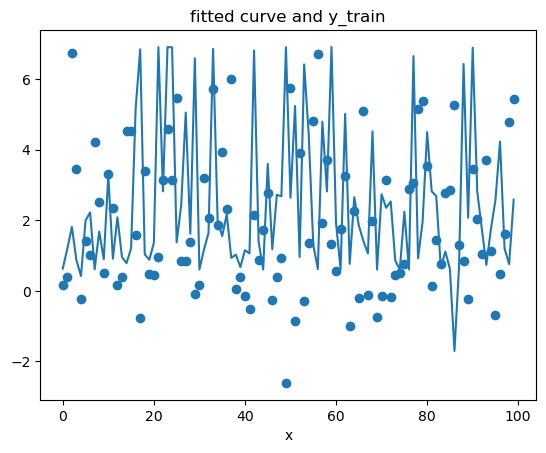

In [148]:
ts = np.dot(Xtilde_train, ridge_regression(Xtilde_train, y_train, lambda_))
import matplotlib.pyplot as plt

plt.plot(ts)
plt.xlabel('x')
plt.scatter(range(y_test.size), y_test)


plt.title('fitted curve and y_train')
plt.legend
plt.show()



Also compute the in error and out error and print it

In [149]:
from sklearn.metrics import mean_squared_error
E_in = mean_squared_error(y_train, ts) #sum over the differences squared and this sum divided by number of data points
E_out = mean_squared_error(y_test, np.dot(Xtilde_test, ridge_regression(Xtilde_train, y_train, lambda_)))

print("    in-sample error: %.5g" % E_in)
print("out-of-sample error: %.5g" % E_out)

    in-sample error: 1.053
out-of-sample error: 14.636


Execute the cells from "Polynomial fit" downwards again while varying
parameters:

 (1) while fixing `N=100`, vary the polynomial order `K`
 
 (2) while fixing `K=20`, vary the number of data points
 
 (3) take a case high `K` and low `N` and vary `lambda_`
 
What do you observe for in- and out-error in those cases, and why?

the error seems to shrink for higher polynomial order and first shrink with higher K, but then increase again. for lower lambda_s it seems to be smaller

Analyze behaviour of Ein and Eout
--------------------------------------

Now pack the code you wrote above into a single function, which takes `Xtilde` and `y`
as well as `K`, `N`, and `lambda_` as inputs and returns the a
list of two elements: `E_in` and `E_out`.

In [150]:
def performance(Xtilde, y, K, N, lambda_):
    Xtilde_train = np.zeros( (int(N/2), int(K)) )

    for i in range(int(N/2)):
        for j in range(int(K)):
            Xtilde_train[i, j] = Xtilde[i, j]

    Xtilde_test = np.zeros( (int(N/2), int(K)))
    for i in range(int(N/2), int(N)):
        for j in range(int(K)):
            Xtilde_test[i - (int(N/2)), j] = Xtilde[i, j]
        
    y_train = np.zeros(int(N/2))
    for i in range(int(N/2)):
        y_train[i] = y[i]
    
    y_test = np.zeros(int(N/2))
    for i in range(int(N/2), int(N)):
        y_test[i - (int(N/2))] = y[i]
        
    ts = np.dot(Xtilde_train, ridge_regression(Xtilde_train, y_train, lambda_))
    from sklearn.metrics import mean_squared_error
    E_in = mean_squared_error(y_train, ts) #sum over the differences squared and this sum divided by number of data points
    E_out = mean_squared_error(y_test, np.dot(Xtilde_test, ridge_regression(Xtilde_train, y_train, lambda_)))
    return [E_in, E_out]

In [151]:
performance(Xtilde, y, 10, 100, 0.0)

[0.7826684799974514, 1.0790301036344827]

In [152]:
assert len(performance(Xtilde, y, 10, 100, 0.1)) == 2

np.testing.assert_allclose(
    performance(Xtilde, y, 10, 1000, 0.1), [1.129271, 1.218699], rtol=2e-1)

I will now plot the fitting peformance over the number of features
and the number of observations, respectively.

Explain these graphs below

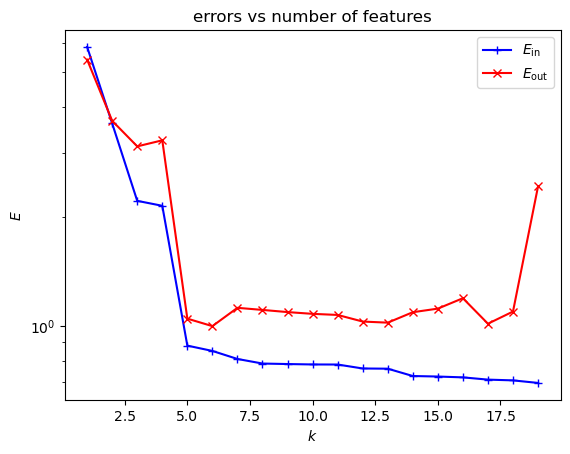

In [153]:
k = np.arange(1,20)
E_in, E_out = np.transpose(
    [performance(Xtilde, y, ki, 100, 0.0) for ki in k])

pl.plot(k, E_in, '-+b', label=r'$E_\mathrm{in}$')
pl.plot(k, E_out, '-xr', label=r'$E_\mathrm{out}$')
pl.title('errors vs number of features')
pl.xlabel('$k$')
pl.ylabel('$E$')
pl.yscale('log')
pl.legend()

In [154]:
n = np.arange(30,200)
E_in, E_out = np.transpose(
    [performance(Xtilde, y, 10, ni, 0.0) for ni in n])

pl.plot(n, E_in, '-b', label=r'$E_\mathrm{in}$')
pl.plot(n, E_out, '-r', label=r'$E_\mathrm{out}$')
pl.title('errors vs number of observations')
pl.xlabel('$N$')
pl.ylabel('$E$')
pl.yscale('log')
pl.legend()

IndexError: index 15 is out of bounds for axis 0 with size 15

one clearly sees that until 5 there is underfitting and at around 12.5 overfitting startsYOUR ANSWER HERE